# Ensemble Learning through Soft Bagging 

**bagging == Bootstrapping Aggregation** 

$\implies$  hyperparam = {M = #learners, alpha = # relative trainset size}

**soft voting**

$ \hat{y} = (\sum_{i = 0}^M \frac{\mu_i}{\sigma_i + \epsilon} )(\sum_i \sigma_i + \epsilon )$


In [1]:
## colab
import sys,os
!git clone -b mpi https://github.com/tlpss/ML-Project2.git
sys.path.append(os.path.abspath(os.path.join('./ML-Project2')))

Cloning into 'ML-Project2'...
remote: Enumerating objects: 453, done.
remote: Counting objects: 100% (453/453), done.
remote: Compressing objects: 100% (314/314), done.
remote: Total 453 (delta 263), reused 295 (delta 124), pack-reused 0
Receiving objects: 100% (453/453), 1.48 MiB | 22.34 MiB/s, done.
Resolving deltas: 100% (263/263), done.


In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from stochastic_models import *
from visualisations import *

from aggregating.gridsearch import create_logger, evaluate_model
from aggregating.utils import flatten_X
from aggregating.models import SoftBagger

## Parameter Configuration

In [3]:
np.random.seed(2020)

In [4]:
N_train = 5000
N_test = 50000
d = 1
T = 2

In [5]:
lambda_range = (N_train*1e-9 , N_train*1e-3)
alpha_range = (8.3*1e-5, 0.83)
length_scale = np.sort(1/np.sqrt((2*alpha_range[0], 2*alpha_range[1])))

## Create Kernel & prepare datasets

In [6]:
#kernel
kernel = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) \
        + WhiteKernel(noise_level= (lambda_range[0] + lambda_range[1])/2 , noise_level_bounds=lambda_range)


In [7]:
#generate drivers
s_train = MaxCallStochasticModel(N_train,d,[1/12,11/12])
s_train.generate_samples()
s_test = MaxCallStochasticModel(N_test, d, [1/12,11/12])
s_test.generate_samples()

In [8]:
#prepare datasets & values
y_train = s_train.y
X_train = s_train.X
S_train = s_train.S

y_test = s_test.y
X_test = s_test.X
S_test = s_test.S

V_T = y_test  
V_0 = s_test.generate_true_V(0)

V_0= V_0.mean()
V_0 # Average expected PROFIT!

0.07935344411249907

In [9]:
X_test.shape

(50000, 1, 2)

## Compare with Hard voting

In [10]:
##

from aggregating.models import SoftBagger, SimpleBagger
from aggregating.utils import flatten_X
soft = SoftBagger(3,0.8,GaussianProcessRegressor(kernel,copy_X_train=False))
hard = SimpleBagger(3,0.8,GaussianProcessRegressor(kernel,copy_X_train=False))
soft.fit(flatten_X(X_train),y_train)
hard.fit(flatten_X(X_train),y_train)

#compare soft & hard prediction
from aggregating.utils import normalized_error_VT
print(normalized_error_VT(y_test, soft.predict(flatten_X(X_test)), V_0))
print(normalized_error_VT(y_test, hard.predict(flatten_X(X_test)), V_0))

In [11]:
#
#x  =  X_test[1023]
#for predictor in soft.predictors:
#    print(predictor.predict(x,return_std=True))
#print(soft.predictors[0].kernel)
#print(soft.predictors[1].kernel)

In [12]:
from sklearn.base import clone
gpr1  = GaussianProcessRegressor(kernel,copy_X_train=False)
gpr2  = clone(gpr1)
gpr1.fit(flatten_X(X_train[2:10]),y_train[2:10])
gpr2.fit(flatten_X(X_train[12:20]),y_train[12:20])

print(gpr1.predict(X_test[4],return_std = True))
print(gpr2.predict(X_test[4],return_std = True))

(array([0.11668687]), array([0.05785658]))
(array([0.06577228]), array([0.10983612]))


## GridSearch

nB: cannot use Scikit gridsearch as it performs CV and we want to have a different test set of a larger size!

In [13]:
#reference error: no ensemble


hyperparams= {'M':1, 'train_size_alpha':1.0}
model = GaussianProcessRegressor(kernel)
reference_error = evaluate_model(model,hyperparams,flatten_X(X_train),y_train,1, [1/12,11/12],5,100000,MaxCallStochasticModel)
reference_error_mean = sum(reference_error)/len(reference_error)
print(reference_error_mean)

 {'M': 1, 'train_size_alpha': 1.0} -> thread id = 140009001363328
{'M': 1, 'train_size_alpha': 1.0} , 0 -> 0.14469663945973618
{'M': 1, 'train_size_alpha': 1.0} , 1 -> 0.1315040996365739
{'M': 1, 'train_size_alpha': 1.0} , 2 -> 0.15907744203335178
{'M': 1, 'train_size_alpha': 1.0} , 3 -> 0.13804245728837544
{'M': 1, 'train_size_alpha': 1.0} , 4 -> 0.1361696254468713
{'M': 1, 'train_size_alpha': 1.0} -> [0.14469663945973618, 0.1315040996365739, 0.15907744203335178, 0.13804245728837544, 0.1361696254468713]
0.1418980527729817


In [14]:
from multiprocessing import  cpu_count,current_process
from multiprocessing.pool import ThreadPool
import functools
import threading


# GRIDSEARCH PARAMS
model = SoftBagger(0,0,GaussianProcessRegressor(kernel,copy_X_train=False))
trials = 3
M_grid = [1,3,5,7,9]
alpha_grid = [0.2,0.3,0.4,0.5]
results = []

### ACTUAL GRIDSEARCH
pool = ThreadPool(2) #hyperthreading 
for m in M_grid:
    for alpha in alpha_grid:
        hyperparams= {'M':m, 'train_size_alpha':alpha}
        pool.apply_async(evaluate_model, args=(model,hyperparams,flatten_X(X_train),y_train,1, [1/12,11/12],trials,N_test,MaxCallStochasticModel,V_0,None,[2020,2021,2022]),callback = create_logger(hyperparams,results))
pool.close()
pool.join()



 {'M': 1, 'train_size_alpha': 0.2} -> thread id = 140008288184064
fit
(5000, 2)
 {'M': 1, 'train_size_alpha': 0.3} -> thread id = 140008279791360
fit
(5000, 2)
 soft predict
(50000, 2)
 soft predict
(50000, 2)
{'M': 1, 'train_size_alpha': 0.2} , 0 -> 0.22261526679701296
 soft predict
(50000, 2)
{'M': 1, 'train_size_alpha': 0.3} , 0 -> 0.16273217733760342
 soft predict
(50000, 2)
{'M': 1, 'train_size_alpha': 0.2} , 1 -> 0.23463680268837922
 soft predict
(50000, 2)
{'M': 1, 'train_size_alpha': 0.3} , 1 -> 0.1763960349201307
 soft predict
(50000, 2)
{'M': 1, 'train_size_alpha': 0.2} , 2 -> 0.21787666659850946
{'M': 1, 'train_size_alpha': 0.2} -> [0.22261526679701296, 0.23463680268837922, 0.21787666659850946]
 {'M': 1, 'train_size_alpha': 0.4} -> thread id = 140008288184064
logger {'M': 1, 'train_size_alpha': 0.2}, -> [0.22261526679701296, 0.23463680268837922, 0.21787666659850946]
fit
(5000, 2)
{'M': 1, 'train_size_alpha': 0.3} , 2 -> 0.15458612463101926
{'M': 1, 'train_size_alpha': 0.3} -

In [15]:
converted_results = np.ones((len(M_grid),len(alpha_grid),trials))*(-1)
for item in results:
    print(item)
    converted_results[M_grid.index(item[0]),alpha_grid.index(item[1])] = item[2]

print(converted_results.shape)
print(converted_results)

[1, 0.2, [0.22261526679701296, 0.23463680268837922, 0.21787666659850946]]
[1, 0.3, [0.16273217733760342, 0.1763960349201307, 0.15458612463101926]]
[1, 0.4, [0.1846541623022965, 0.2133472214574922, 0.21778405575238682]]
[1, 0.5, [0.14248851405655863, 0.15918576321666902, 0.16660779915500862]]
[3, 0.2, [0.11276971524447511, 0.12682011638515028, 0.12119919154019855]]
[3, 0.3, [0.13742421125355048, 0.1535012304211044, 0.1504570079709425]]
[3, 0.4, [0.13962986134032215, 0.1521038811668313, 0.16111615879649366]]
[3, 0.5, [0.12508112942216215, 0.1336038275630905, 0.13945385126362697]]
[5, 0.2, [0.11198646612399402, 0.12294716754581123, 0.11879628771633076]]
[5, 0.3, [0.11808861220556148, 0.13294500568817935, 0.1319737811268167]]
[5, 0.4, [0.11865641565464927, 0.12698947586659123, 0.13668114132815679]]
[5, 0.5, [0.1281885760531762, 0.13915758861289138, 0.15057387335460853]]
[7, 0.2, [0.114766542844548, 0.12810808684132308, 0.12259351007575611]]
[7, 0.3, [0.12327316590711314, 0.13761057105947, 

In [16]:
masked_results= np.ma.masked_where(converted_results <= 0.0,converted_results) # some runs have been aborted every now and then -> filter them out
means = masked_results.mean(axis=2)
sigmas = masked_results.std(axis=2)
means.shape

(5, 4)

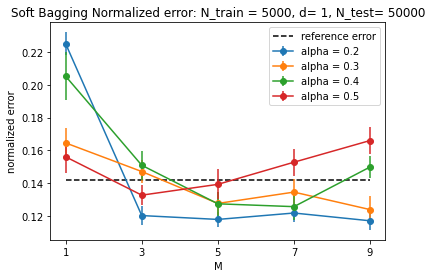

In [17]:
plt.hlines(reference_error_mean,xmin=M_grid[0],xmax=M_grid[-1],linestyles='dashed',label="reference error")
for i in range(len(alpha_grid)):
    plt.errorbar(np.array(M_grid),means[:,i],sigmas[:,i],marker ='o',label = f"alpha = {alpha_grid[i]}")
plt.title(f"Soft Bagging Normalized error: N_train = {N_train}, d= {d}, N_test= {N_test}")
plt.xlabel("M")
plt.xticks(M_grid)
plt.ylabel("normalized error")
plt.legend(loc='upper right')
plt.savefig("soft_bagging.png")
plt.show()


## Store results

In [18]:
res_dict = {'N_train': N_train, 'N_test': N_test,'mgrid': M_grid, 'alpha_grid': alpha_grid, 'errors': converted_results.tolist()}

In [19]:
import json
import datetime
with open(f'soft_bagging_w_replacement_{str(datetime.date.today())}.json', 'w') as fp:
    json.dump(res_dict, fp)